In [1]:
from federated_learning.dataloader import MNISTDataloader
from federated_learning.configuration import Configuration
import torch 


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Configuration 

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
config = Configuration()
mnist = MNISTDataloader(config)
examples = enumerate(mnist.train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape


MNIST training loader loaded.
MNIST test loader loaded.


torch.Size([64, 1, 28, 28])

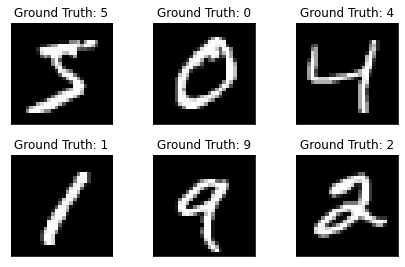

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

# Poison Data


In [6]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

def poison_data(): 
    data = mnist.train_dataloader.dataset.data.numpy()
    labels = mnist.train_dataloader.dataset.train_labels.numpy()
    labels = np.where(labels==0, 9, labels) 
    dataset = TensorDataset(Tensor(data).unsqueeze(1), Tensor(labels) )
    return torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size_train)

poison_loader = poison_data()


/opt/conda/lib/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [7]:
examples = enumerate(poison_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape


torch.Size([64, 1, 28, 28])

In [8]:
import matplotlib.pyplot as plt
#for batch_ndx, sample in enumerate(poison_loader):
#    print(sample)

In [9]:
# SHAP index
#first_index = []
##for i in range(10):
#    index = np.where(example_targets==i)
#    first_index.append(index[0][0])
#print(first_index)

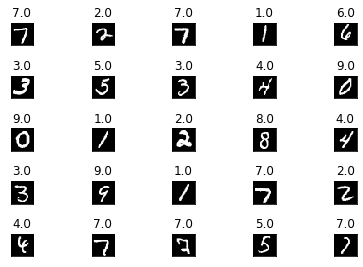

In [10]:
import matplotlib.pyplot as plt


fig = plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

# Train Model

## Network

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [13]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [14]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(poison_loader.dataset) for i in range(n_epochs)]

In [22]:
# Train and Test Funktions
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(poison_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(poison_loader.dataset),100. * batch_idx / len(poison_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(poison_loader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in mnist.test_dataloader:
            output = network(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            total += 1
            print(test_loss, loss, total)
    test_loss /= total
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(mnist.test_dataloader.dataset), 100. * correct / len(mnist.test_dataloader.dataset)))

In [23]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/tmp/ipykernel_15692/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


2.311776876449585 tensor(2.3118) 1
4.619685173034668 tensor(2.3079) 2
6.9268622398376465 tensor(2.3072) 3
9.23439645767212 tensor(2.3075) 4
11.542823076248169 tensor(2.3084) 5
13.848642587661743 tensor(2.3058) 6
16.15609049797058 tensor(2.3074) 7
18.464669704437256 tensor(2.3086) 8
20.770416021347046 tensor(2.3057) 9
23.07753038406372 tensor(2.3071) 10

Test set: Avg. loss: 2.3078, Accuracy: 1018/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 24.071301
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.197422
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.261171
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.991116
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.846895
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.562301
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.569715
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.650348
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.377894
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.399167
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.312833
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.303750
Train Epoch